In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import random_split

import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import pyro.infer
import pyro.optim

import arviz as az
import matplotlib.pyplot as plt

torch.manual_seed(0)

/Users/aleynakara/miniconda3/envs/ml4rg/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv(f'{os.getcwd()}/data/mean_tpm.csv', index_col=0)

In [3]:
# Function to uniformly sample from each group
def uniform_sample(df, group_cols, n_samples_per_group=1):
    # Group by the specified columns
    grouped = df.groupby(group_cols)
    
    # Uniformly sample n_samples_per_group from each group
    sampled_df = grouped.apply(lambda x: x.sample(n=min(len(x), n_samples_per_group)))
    
    # Reset index to flatten the DataFrame
    sampled_df = sampled_df.reset_index(drop=True)
    
    return sampled_df

# Columns to group by
group_cols = ['species']

# Number of samples to take from each group
n_samples_per_group = 100

# Get the uniformly sampled DataFrame
sampled_df = df #uniform_sample(df, group_cols, n_samples_per_group)

In [4]:
# import pyro
# import pyro.distributions as dist
# import torch
# import torch.nn as nn
# import pyro.optim as optim
# from pyro.infer import SVI, Trace_ELBO
# from pyro.nn import PyroModule, PyroSample
# from torch.utils.data import DataLoader, TensorDataset, random_split
# from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt


# enc_species = OneHotEncoder()
# encoded_species = enc_species.fit_transform(sampled_df[['species']]).toarray()

# enc_stress = OneHotEncoder()
# encoded_stress_condition = enc_stress.fit_transform(sampled_df[['stress_condition']]).toarray()

# # Function to one-hot encode DNA sequence
# def one_hot_encode_sequence(sequence, max_length=200):
#     mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
#     one_hot_encoded = np.zeros((max_length, 4))
#     for i, nucleotide in enumerate(sequence[:max_length]):
#         if nucleotide in mapping:
#             one_hot_encoded[i, mapping[nucleotide]] = 1
#     return one_hot_encoded

# # Apply one-hot encoding to the DNA sequences
# max_length = sampled_df['upstream200'].apply(len).max()
# sequences = sampled_df['upstream200'].apply(lambda seq: one_hot_encode_sequence(seq, max_length=max_length))
# sequences = np.array(sequences.tolist())

# # Convert to PyTorch tensors
# sequence_tensor = torch.tensor(sequences, dtype=torch.float32).permute(0, 2, 1)
# species_tensor = torch.tensor(encoded_species, dtype=torch.float32)
# stress_tensor = torch.tensor(encoded_stress_condition, dtype=torch.float32)

# # Log transform TPM values and then scale using MinMaxScaler
# y_log = np.log1p(sampled_df['mean_tpm'].values)
# scaler = MinMaxScaler()
# y_scaled = scaler.fit_transform(y_log.reshape(-1, 1)).flatten()
# y_tensor = torch.tensor(y_scaled, dtype=torch.float32).unsqueeze(1)

# # Create dataset
# dataset = TensorDataset(sequence_tensor, species_tensor, stress_tensor, y_tensor)

# # Split dataset into train, validation, and test sets
# train_size = int(0.8 * len(dataset))
# val_size = int(0.1 * len(dataset))
# test_size = len(dataset) - train_size - val_size

# train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# batch_size = 256
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # Define a simpler CNN model with additional layers and dropout
# class DNA_CNN(PyroModule):
#     def __init__(self, seq_length, num_stress_conditions, num_species, output_dim):
#         super().__init__()
#         self.conv1 = nn.Conv1d(in_channels=4, out_channels=16, kernel_size=3, stride=1)
#         self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1)
#         self.fc1 = PyroModule[nn.Linear](32 * (seq_length - 4), 128)
#         self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([128, 32 * (seq_length - 4)]).to_event(2))
#         self.fc1.bias = PyroSample(dist.Normal(0., 1.).expand([128]).to_event(1))
#         self.fc2 = PyroModule[nn.Linear](128 + num_stress_conditions + num_species, output_dim)
#         self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([output_dim, 128 + num_stress_conditions + num_species]).to_event(2))
#         self.fc2.bias = PyroSample(dist.Normal(0., 1.).expand([output_dim]).to_event(1))
#         self.dropout = nn.Dropout(0.5)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x, stress_cond, species):
#         x = torch.relu(self.conv1(x))
#         x = torch.relu(self.conv2(x))
#         x = x.view(x.size(0), -1)
#         x = self.dropout(torch.relu(self.fc1(x)))
#         x = torch.cat([x, stress_cond, species], dim=1)
#         x = self.fc2(x)
#         return self.sigmoid(x)

# # Define the model
# def model(dna_seq, stress_cond, species, target=None):
#     cnn = DNA_CNN(seq_length=dna_seq.size(2), 
#                   num_stress_conditions=stress_cond.size(1), 
#                   num_species=species.size(1), 
#                   output_dim=1)
#     mean = cnn(dna_seq, stress_cond, species)
#     sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
#     with pyro.plate("data", size=dna_seq.size(0)):
#         obs = pyro.sample("obs", dist.Normal(mean, sigma).to_event(1), obs=target)
#     return mean

# # Define the guide
# def guide(dna_seq, stress_cond, species, target=None):
#     cnn = DNA_CNN(seq_length=dna_seq.size(2), 
#                   num_stress_conditions=stress_cond.size(1), 
#                   num_species=species.size(1), 
#                   output_dim=1)
#     pyro.module("cnn", cnn)
#     sigma_loc_unconstrained = pyro.param("sigma_loc_unconstrained", torch.tensor(1.))
#     sigma_loc = torch.sigmoid(sigma_loc_unconstrained) * 10
#     pyro.sample("sigma", dist.Delta(sigma_loc))
#     return cnn(dna_seq, stress_cond, species)

# # Training setup
# pyro.clear_param_store()
# adam = optim.Adam({"lr": 0.001})  # Reduced learning rate
# svi = SVI(model, guide, adam, loss=Trace_ELBO())

# num_steps = 10
# train_losses = []
# val_losses = []

# for step in range(num_steps):
#     # Training step
#     epoch_train_loss = 0
#     for batch in train_loader:
#         dna_seq, species, stress_cond, target = batch
#         loss = svi.step(dna_seq, stress_cond, species, target)
#         epoch_train_loss += loss
#     avg_train_loss = epoch_train_loss / len(train_loader.dataset)
#     train_losses.append(avg_train_loss)

#     # Validation step
#     epoch_val_loss = 0
#     for batch in val_loader:
#         dna_seq, species, stress_cond, target = batch
#         val_loss = svi.evaluate_loss(dna_seq, stress_cond, species, target)
#         epoch_val_loss += val_loss
#     avg_val_loss = epoch_val_loss / len(val_loader.dataset)
#     val_losses.append(avg_val_loss)

#     print(f"Step {step:04d} : Avg Train Loss = {avg_train_loss:.4f}, Avg Val Loss = {avg_val_loss:.4f}")

# print("Training complete.")

# # Test evaluation
# epoch_test_loss = 0
# predictions = []
# actuals = []
# for batch in test_loader:
#     dna_seq, species, stress_cond, target = batch
#     test_loss = svi.evaluate_loss(dna_seq, stress_cond, species, target)
#     epoch_test_loss += test_loss
    
#     # Compute predictions
#     with torch.no_grad():
#         pred = pyro.module("cnn", DNA_CNN(seq_length=dna_seq.size(2), 
#                                           num_stress_conditions=stress_cond.size(1), 
#                                           num_species=species.size(1), 
#                                           output_dim=1)).forward(dna_seq, stress_cond, species)
#     predictions.extend(pred.squeeze().numpy())
#     actuals.extend(target.squeeze().numpy())

# avg_test_loss = epoch_test_loss / len(test_loader.dataset)
# print(f"Test Loss: {avg_test_loss:.4f}")

# # Transform predictions back to the original scale
# predictions_exp = np.expm1(scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten())
# actuals_exp = np.expm1(scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten())

# # Plotting the training, validation, and test losses
# plt.figure(figsize=(10, 5))
# plt.plot(train_losses, label='Training Loss')
# plt.plot(val_losses, label='Validation Loss')
# plt.axhline(y=avg_test_loss, color='r', linestyle='--', label='Test Loss')
# plt.xlabel('Step')
# plt.ylabel('Loss')
# plt.title('Training, Validation, and Test Losses')
# plt.legend()
# plt.show()

# # Plotting predictions vs actuals on the original scale
# plt.figure(figsize=(10, 5))
# plt.scatter(actuals_exp, predictions_exp, alpha=0.6)
# plt.plot([min(actuals_exp), max(actuals_exp)], [min(actuals_exp), max(actuals_exp)], color='red', linestyle='--')
# plt.xlabel('Actual TPM')
# plt.ylabel('Predicted TPM')
# plt.title('Predictions vs Actuals')
# plt.show()

In [5]:
import pyro
import pyro.distributions as dist
import torch
import torch.nn as nn
import pyro.optim as optim
from pyro.infer import SVI, Trace_ELBO
from pyro.nn import PyroModule, PyroSample
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

enc_species = OneHotEncoder()
encoded_species = enc_species.fit_transform(sampled_df[['species']]).toarray()

enc_stress = OneHotEncoder()
encoded_stress_condition = enc_stress.fit_transform(sampled_df[['stress_condition']]).toarray()

# Function to one-hot encode DNA sequence
def one_hot_encode_sequence(sequence, max_length=200):
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    one_hot_encoded = np.zeros((max_length, 4))
    for i, nucleotide in enumerate(sequence[:max_length]):
        if nucleotide in mapping:
            one_hot_encoded[i, mapping[nucleotide]] = 1
    return one_hot_encoded

# Apply one-hot encoding to the DNA sequences
max_length = sampled_df['upstream200'].apply(len).max()
sequences = sampled_df['upstream200'].apply(lambda seq: one_hot_encode_sequence(seq, max_length=max_length))
sequences = np.array(sequences.tolist())

# Convert to PyTorch tensors
sequence_tensor = torch.tensor(sequences, dtype=torch.float32).permute(0, 2, 1)
species_tensor = torch.tensor(encoded_species, dtype=torch.float32)
stress_tensor = torch.tensor(encoded_stress_condition, dtype=torch.float32)

# Log transform TPM values and then scale using StandardScaler
y_log = np.log1p(sampled_df['mean_tpm'].values)
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y_log.reshape(-1, 1)).flatten()
y_tensor = torch.tensor(y_scaled, dtype=torch.float32).unsqueeze(1)

# Create dataset
dataset = TensorDataset(sequence_tensor, species_tensor, stress_tensor, y_tensor)

# Split dataset into train, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define an advanced CNN model
class Advanced_DNA_CNN(PyroModule):
    def __init__(self, seq_length, num_stress_conditions, num_species, output_dim):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc1 = PyroModule[nn.Linear](128 * (seq_length // 8), 256)
        self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([256, 128 * (seq_length // 8)]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 1.).expand([256]).to_event(1))
        self.fc2 = PyroModule[nn.Linear](256 + num_stress_conditions + num_species, output_dim)
        self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([output_dim, 256 + num_stress_conditions + num_species]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 1.).expand([output_dim]).to_event(1))
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x, stress_cond, species):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = torch.cat([x, stress_cond, species], dim=1)
        x = self.fc2(x)
        return x 

# Define the model
def model(dna_seq, stress_cond, species, target=None):
    cnn = Advanced_DNA_CNN(seq_length=dna_seq.size(2), 
                           num_stress_conditions=stress_cond.size(1), 
                           num_species=species.size(1), 
                           output_dim=1)
    mean = cnn(dna_seq, stress_cond, species)
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    with pyro.plate("data", size=dna_seq.size(0)):
        obs = pyro.sample("obs", dist.Normal(mean, sigma).to_event(1), obs=target)
    return mean

# Define the guide
def guide(dna_seq, stress_cond, species, target=None):
    cnn = Advanced_DNA_CNN(seq_length=dna_seq.size(2), 
                           num_stress_conditions=stress_cond.size(1), 
                           num_species=species.size(1), 
                           output_dim=1)
    pyro.module("cnn", cnn)
    sigma_loc_unconstrained = pyro.param("sigma_loc_unconstrained", torch.tensor(1.))
    sigma_loc = torch.sigmoid(sigma_loc_unconstrained) * 10
    pyro.sample("sigma", dist.Delta(sigma_loc))
    return cnn(dna_seq, stress_cond, species)

# Training setup
pyro.clear_param_store()
adam = optim.Adam({"lr": 0.001})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

num_steps = 10
train_losses = []
val_losses = []

for step in range(num_steps):
    # Training step
    epoch_train_loss = 0
    for batch in train_loader:
        dna_seq, species, stress_cond, target = batch
        loss = svi.step(dna_seq, stress_cond, species, target)
        epoch_train_loss += loss
    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Validation step
    epoch_val_loss = 0
    for batch in val_loader:
        dna_seq, species, stress_cond, target = batch
        val_loss = svi.evaluate_loss(dna_seq, stress_cond, species, target)
        epoch_val_loss += val_loss
    avg_val_loss = epoch_val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)

    print(f"Step {step:04d} : Avg Train Loss = {avg_train_loss:.4f}, Avg Val Loss = {avg_val_loss:.4f}")

print("Training complete.")

# Test evaluation
epoch_test_loss = 0
predictions = []
actuals = []
for batch in test_loader:
    dna_seq, species, stress_cond, target = batch
    test_loss = svi.evaluate_loss(dna_seq, stress_cond, species, target)
    epoch_test_loss += test_loss
    
    # Compute predictions
    with torch.no_grad():
        pred = pyro.module("cnn", Advanced_DNA_CNN(seq_length=dna_seq.size(2), 
                                                   num_stress_conditions=stress_cond.size(1), 
                                                   num_species=species.size(1), 
                                                   output_dim=1)).forward(dna_seq, stress_cond, species)
    predictions.extend(pred.squeeze().numpy())
    actuals.extend(target.squeeze().numpy())

avg_test_loss = epoch_test_loss / len(test_loader.dataset)
print(f"Test Loss: {avg_test_loss:.4f}")

# Transform predictions back to the original scale
predictions_exp = np.expm1(scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten())
actuals_exp = np.expm1(scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten())

# Plotting the training, validation, and test losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label='Test Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Losses')
plt.legend()
plt.show()

# Plotting predictions vs actuals on the original scale
plt.figure(figsize=(10, 5))
plt.scatter(actuals_exp, predictions_exp, alpha=0.6)
plt.plot([min(actuals_exp), max(actuals_exp)], [min(actuals_exp), max(actuals_exp)], color='red', linestyle='--')
plt.xlabel('Actual TPM')
plt.ylabel('Predicted TPM')
plt.title('Predictions vs Actuals')
plt.show()

KeyboardInterrupt: 

In [ ]:
sampled_df['mean_tpm'].describe()

0

In [ ]:
sampled_df.groupby('stress_condition')['mean_tpm'].describe()

,count,mean,std,min,25%,50%,75%,max
stress_condition,,,,,,,,
achx_bs,3.0,56.855182,27.559768,37.364448,41.089562,44.814676,66.600549,88.386422
achx_li,1.0,132.162903,NaN,132.162903,132.162903,132.162903,132.162903,132.162903
achx_mig,1.0,3.956117,NaN,3.956117,3.956117,3.956117,3.956117,3.956117
achx_nd,1.0,17.257087,NaN,17.257087,17.257087,17.257087,17.257087,17.257087
achx_oss,1.0,57.363626,NaN,57.363626,57.363626,57.363626,57.363626,57.363626
...,...,...,...,...,...,...,...,...
vibrio_mig,1.0,95.727850,NaN,95.727850,95.727850,95.727850,95.727850,95.727850
vibrio_nd,1.0,55.895252,NaN,55.895252,55.895252,55.895252,55.895252,55.895252
vibrio_oss,3.0,199.862415,122.405322,59.379783,158.005001,256.630219,270.103730,283.577242


In [ ]:
predictions

[-424.5445,
 -513.8342,
 -422.1983,
 -1210.9904,
 -1519.9146,
 -1299.1016,
 242.31718,
 -1547.6986,
 -2593.9766,
 -1794.0813,
 -547.5931,
 394.52603,
 511.1765,
 -2520.0483,
 -63.557644,
 -1694.601,
 -295.12955,
 -210.81859,
 279.55756,
 -805.6365,
 -2377.6064,
 -360.2283,
 -871.35486,
 -759.3534,
 -766.83813,
 -190.13222,
 924.17926,
 -451.61743,
 -492.1389,
 141.21259,
 -368.1501,
 -730.9878,
 -1922.8251,
 -129.40358,
 42.67087,
 -1482.6095,
 -1137.9196,
 577.2617,
 740.5124,
 764.9731,
 -640.949,
 -234.4922,
 135.93358,
 -844.1199,
 377.11014,
 856.6418,
 -235.32996,
 -1017.4223,
 -1269.492,
 -1068.0684,
 -27.744886,
 -1195.1627,
 -2732.3457,
 -2011.5735,
 -533.7248,
 -766.6118,
 840.7276,
 -2052.3748,
 -1155.6117,
 -321.89136,
 -903.6078,
 1029.6964,
 -508.8374,
 -139.39156,
 -858.0468,
 -744.45184,
 81.55104,
 -747.0298,
 -2498.2844,
 182.91753,
 -321.21088,
 -1294.466,
 -227.78877,
 -941.2684,
 -1736.2358,
 -860.1134,
 -857.15906,
 -1123.6406,
 -2111.4712,
 -1875.7317,
 6.2486897

/var/folders/24/jbn800492ks0n353ktq87jp00000gn/T/ipykernel_14146/3702346470.py:2: RuntimeWarning: overflow encountered in expm1
  predictions_exp = np.expm1(scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten())


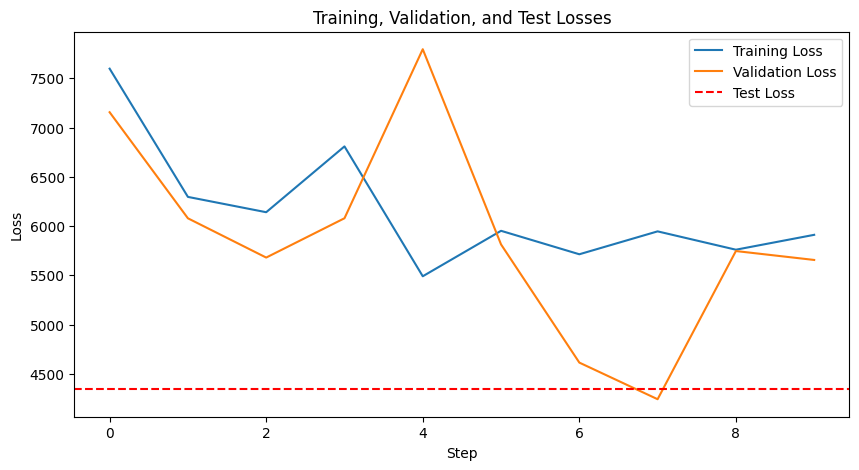

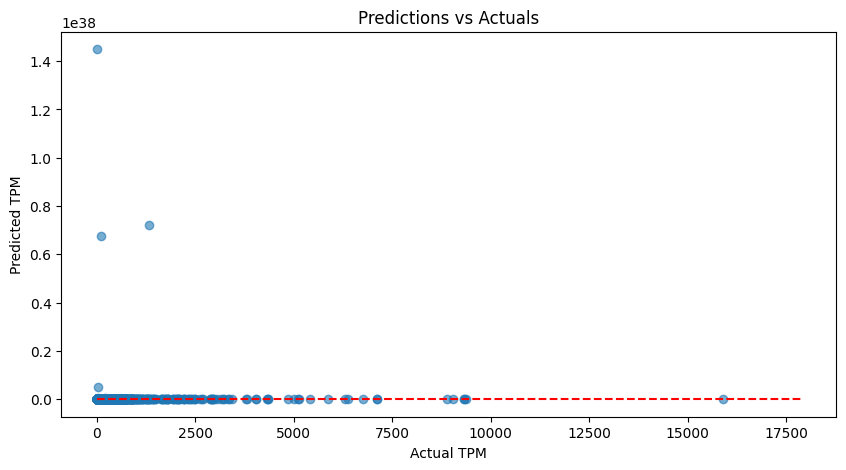

In [ ]:
# Transform predictions back to the original scale
predictions_exp = np.expm1(scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten())
actuals_exp = np.expm1(scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten())

# Plotting the training, validation, and test losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label='Test Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Losses')
plt.legend()
plt.show()

# Plotting predictions vs actuals on the original scale
plt.figure(figsize=(10, 5))
plt.scatter(actuals_exp, predictions_exp, alpha=0.6)
plt.plot([min(actuals_exp), max(actuals_exp)], [min(actuals_exp), max(actuals_exp)], color='red', linestyle='--')
plt.xlabel('Actual TPM')
plt.ylabel('Predicted TPM')
plt.title('Predictions vs Actuals')
plt.show()

In [ ]:
sampled_df

,species,upstream200,stress_condition,mean_tpm
0,Achromobacter xylosoxidans SOLR10,GTTGCCAAGGCATCCAACGCGCCGTCGCCGACGCCGTCGAACCAGG...,achx_mig,3.956117
1,Achromobacter xylosoxidans SOLR10,CTTCACCGCCATCAAGGGAGAGATTCCCAGCCCGCTCAACCCGCCC...,achx_nd,17.257087
2,Achromobacter xylosoxidans SOLR10,TCCTGGCGGCCGCCGGCGTCAGCCTGAACTGGCAGTGGCGCCTGCG...,achx_bs,44.814676
3,Achromobacter xylosoxidans SOLR10,GACCATCAATGTGATTTTGTTTTTTCATTCTGCACCAGTTTTATAG...,achx_oxs,6.890346
4,Achromobacter xylosoxidans SOLR10,GGTACGGAATGTCCCATAGTGTAGGACGCGCGCGCACCGTTTCGCC...,achx_bs,88.386422
...,...,...,...,...
22545,Vibrio cholerae O1 biovar El Tor str. N16961,GGTCAGAGTCAATACTGGCATTGTTTTCAGTAAAAAGAGAACAAGA...,vibrio_bs,22.877311
22546,Vibrio cholerae O1 biovar El Tor str. N16961,ATCAATCTAACCCATTTGTCACGGCGGCGAAATGGCAAATCTTGAT...,vibrio_nd,55.895252
22547,Vibrio cholerae O1 biovar El Tor str. N16961,GTCGCCCGATTTCGCGGCGCGCCAGTATATACCTAAGTGCGCTCAA...,vibrio_oss,59.379783
22548,Vibrio cholerae O1 biovar El Tor str. N16961,ATAAAAAACAGTAAGCCGACTCACCGAGTCGGCTTTTTTTTGCCAT...,vibrio_oss,256.630219


In [ ]:
np.array(actuals).max(), np.array(predictions).max()

(3.1574607, 3258.5815)

In [ ]:
np.array(actuals).min(), np.array(predictions).min()

(-3.2938116, -2917.8013)

In [ ]:
actuals

[-0.9890452,
 -1.5920154,
 -0.62453324,
 -0.7948534,
 -1.9950173,
 -0.10636843,
 -0.89771056,
 -1.1390303,
 1.1014259,
 0.7510606,
 0.10903644,
 -0.6222112,
 0.22023688,
 0.48213878,
 2.4241483,
 -0.92081195,
 -1.5712433,
 1.033088,
 1.7855718,
 0.47832957,
 -0.10926361,
 0.07976798,
 -0.48901156,
 0.16301572,
 0.44666836,
 -1.3260701,
 -0.7817207,
 -1.4712785,
 -0.4941788,
 1.8893316,
 -1.3483119,
 0.3343039,
 0.012451654,
 1.1240014,
 1.0954864,
 -0.6493722,
 0.89773804,
 -0.27282566,
 -1.0623394,
 -0.039841633,
 -0.78637767,
 0.51461965,
 0.8950382,
 1.0042145,
 0.41930205,
 -0.367529,
 0.8319558,
 0.3344033,
 -0.084068894,
 0.25692868,
 0.015542905,
 -0.02890918,
 -0.6245671,
 -1.2068182,
 -2.729305,
 0.858048,
 -0.24768049,
 1.6907806,
 0.0015451806,
 -0.98467267,
 0.21092722,
 -0.51119024,
 0.22948864,
 1.5041991,
 2.0282013,
 -0.44619858,
 -0.018179134,
 0.04180439,
 0.6005608,
 1.5151995,
 -0.63502437,
 -0.02881732,
 -0.73885226,
 0.7178423,
 0.4703941,
 0.46473277,
 -0.0486101

In [ ]:
predictions

[-424.5445,
 -513.8342,
 -422.1983,
 -1210.9904,
 -1519.9146,
 -1299.1016,
 242.31718,
 -1547.6986,
 -2593.9766,
 -1794.0813,
 -547.5931,
 394.52603,
 511.1765,
 -2520.0483,
 -63.557644,
 -1694.601,
 -295.12955,
 -210.81859,
 279.55756,
 -805.6365,
 -2377.6064,
 -360.2283,
 -871.35486,
 -759.3534,
 -766.83813,
 -190.13222,
 924.17926,
 -451.61743,
 -492.1389,
 141.21259,
 -368.1501,
 -730.9878,
 -1922.8251,
 -129.40358,
 42.67087,
 -1482.6095,
 -1137.9196,
 577.2617,
 740.5124,
 764.9731,
 -640.949,
 -234.4922,
 135.93358,
 -844.1199,
 377.11014,
 856.6418,
 -235.32996,
 -1017.4223,
 -1269.492,
 -1068.0684,
 -27.744886,
 -1195.1627,
 -2732.3457,
 -2011.5735,
 -533.7248,
 -766.6118,
 840.7276,
 -2052.3748,
 -1155.6117,
 -321.89136,
 -903.6078,
 1029.6964,
 -508.8374,
 -139.39156,
 -858.0468,
 -744.45184,
 81.55104,
 -747.0298,
 -2498.2844,
 182.91753,
 -321.21088,
 -1294.466,
 -227.78877,
 -941.2684,
 -1736.2358,
 -860.1134,
 -857.15906,
 -1123.6406,
 -2111.4712,
 -1875.7317,
 6.2486897

In [ ]:
(np.log1p((sampled_df['mean_tpm']).to_numpy()) <0).sum()

0

In [ ]:
# import pyro
# import pyro.distributions as dist
# import torch
# import torch.nn as nn
# import pyro.optim as optim
# from pyro.infer import SVI, Trace_ELBO
# from pyro.nn import PyroModule, PyroSample
# from torch.utils.data import DataLoader, TensorDataset, random_split
# from sklearn.preprocessing import OneHotEncoder, StandardScaler
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# # Assuming sampled_df is a pandas DataFrame containing 'species', 'stress_condition', 'upstream200', and 'mean_tpm' columns

# # One-hot encode species and stress_condition
# enc_species = OneHotEncoder()
# encoded_species = enc_species.fit_transform(sampled_df[['species']]).toarray()

# enc_stress = OneHotEncoder()
# encoded_stress_condition = enc_stress.fit_transform(sampled_df[['stress_condition']]).toarray()

# # Function to one-hot encode DNA sequence
# def one_hot_encode_sequence(sequence, max_length=200):
#     mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
#     one_hot_encoded = np.zeros((max_length, 4))
#     for i, nucleotide in enumerate(sequence[:max_length]):
#         if nucleotide in mapping:
#             one_hot_encoded[i, mapping[nucleotide]] = 1
#     return one_hot_encoded

# # Apply one-hot encoding to the DNA sequences
# max_length = sampled_df['upstream200'].apply(len).max()
# sequences = sampled_df['upstream200'].apply(lambda seq: one_hot_encode_sequence(seq, max_length=max_length))
# sequences = np.array(sequences.tolist())

# # Normalize the sequences
# sequence_tensor = torch.tensor(sequences, dtype=torch.float32).permute(0, 2, 1)
# scaler = StandardScaler()
# sequence_tensor = torch.tensor(scaler.fit_transform(sequence_tensor.reshape(-1, sequence_tensor.shape[-1])).reshape(sequence_tensor.shape), dtype=torch.float32)

# # Convert to PyTorch tensors
# species_tensor = torch.tensor(encoded_species, dtype=torch.float32)
# stress_tensor = torch.tensor(encoded_stress_condition, dtype=torch.float32)
# y_tensor = torch.tensor(np.log1p(sampled_df['mean_tpm'].values), dtype=torch.float32).unsqueeze(1)

# # Create dataset
# dataset = TensorDataset(sequence_tensor, species_tensor, stress_tensor, y_tensor)

# # Split dataset into train, validation, and test sets
# train_size = int(0.8 * len(dataset))
# val_size = int(0.1 * len(dataset))
# test_size = len(dataset) - train_size - val_size

# train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# batch_size = 256
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # Define the CNN model with additional layers and dropout
# class DNA_CNN(PyroModule):
#     def __init__(self, seq_length, num_stress_conditions, num_species, output_dim):
#         super().__init__()
#         self.conv1 = nn.Conv1d(in_channels=4, out_channels=16, kernel_size=3, stride=1)
#         self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1)
#         self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
#         self.fc1 = PyroModule[nn.Linear](64 * (seq_length - 6), 128)
#         self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([128, 64 * (seq_length - 6)]).to_event(2))
#         self.fc1.bias = PyroSample(dist.Normal(0., 1.).expand([128]).to_event(1))
#         self.fc2 = PyroModule[nn.Linear](128 + num_stress_conditions + num_species, 64)
#         self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([64, 128 + num_stress_conditions + num_species]).to_event(2))
#         self.fc2.bias = PyroSample(dist.Normal(0., 1.).expand([64]).to_event(1))
#         self.fc3 = PyroModule[nn.Linear](64, output_dim)
#         self.fc3.weight = PyroSample(dist.Normal(0., 1.).expand([output_dim, 64]).to_event(2))
#         self.fc3.bias = PyroSample(dist.Normal(0., 1.).expand([output_dim]).to_event(1))
#         self.dropout = nn.Dropout(0.5)

#     def forward(self, x, stress_cond, species):
#         x = torch.relu(self.conv1(x))
#         x = torch.relu(self.conv2(x))
#         x = torch.relu(self.conv3(x))
#         x = x.view(x.size(0), -1)
#         x = self.dropout(torch.relu(self.fc1(x)))
#         x = torch.cat([x, stress_cond, species], dim=1)
#         x = self.dropout(torch.relu(self.fc2(x)))
#         return self.fc3(x)

# # Define the model
# def model(dna_seq, stress_cond, species, target=None):
#     cnn = DNA_CNN(seq_length=dna_seq.size(2), 
#                   num_stress_conditions=stress_cond.size(1), 
#                   num_species=species.size(1), 
#                   output_dim=1)
#     mean = cnn(dna_seq, stress_cond, species)
#     sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
#     with pyro.plate("data", size=dna_seq.size(0)):
#         obs = pyro.sample("obs", dist.Normal(mean, sigma).to_event(1), obs=target)
#     return mean

# # Define the guide
# def guide(dna_seq, stress_cond, species, target=None):
#     cnn = DNA_CNN(seq_length=dna_seq.size(2), 
#                   num_stress_conditions=stress_cond.size(1), 
#                   num_species=species.size(1), 
#                   output_dim=1)
#     pyro.module("cnn", cnn)
#     sigma_loc_unconstrained = pyro.param("sigma_loc_unconstrained", torch.tensor(1.))
#     sigma_loc = torch.sigmoid(sigma_loc_unconstrained) * 10
#     pyro.sample("sigma", dist.Delta(sigma_loc))
#     return cnn(dna_seq, stress_cond, species)

# # Training setup
# pyro.clear_param_store()
# adam = optim.Adam({"lr": 0.001})  # Reduced learning rate
# svi = SVI(model, guide, adam, loss=Trace_ELBO())

# num_steps = 10
# train_losses = []
# val_losses = []
# test_losses = []

# for step in range(num_steps):
#     # Training step
#     epoch_train_loss = 0
#     for batch in train_loader:
#         dna_seq, species, stress_cond, target = batch
#         loss = svi.step(dna_seq, stress_cond, species, target)
#         epoch_train_loss += loss
#     avg_train_loss = epoch_train_loss / len(train_loader.dataset)
#     train_losses.append(avg_train_loss)

#     # Validation step
#     epoch_val_loss = 0
#     for batch in val_loader:
#         dna_seq, species, stress_cond, target = batch
#         val_loss = svi.evaluate_loss(dna_seq, stress_cond, species, target)
#         epoch_val_loss += val_loss
#     avg_val_loss = epoch_val_loss / len(val_loader.dataset)
#     val_losses.append(avg_val_loss)

#     print(f"Step {step:04d} : Avg Train Loss = {avg_train_loss:.4f}, Avg Val Loss = {avg_val_loss:.4f}")

# print("Training complete.")

# # Test evaluation
# epoch_test_loss = 0
# predictions = []
# actuals = []
# for batch in test_loader:
#     dna_seq, species, stress_cond, target = batch
#     test_loss = svi.evaluate_loss(dna_seq, stress_cond, species, target)
#     epoch_test_loss += test_loss
    
#     # Compute predictions
#     with torch.no_grad():
#         pred = pyro.module("cnn", DNA_CNN(seq_length=dna_seq.size(2), 
#                                           num_stress_conditions=stress_cond.size(1), 
#                                           num_species=species.size(1), 
#                                           output_dim=1)).forward(dna_seq, stress_cond, species)
#     predictions.extend(pred.squeeze().numpy())
#     actuals.extend(target.squeeze().numpy())

# avg_test_loss = epoch_test_loss / len(test_loader.dataset)
# test_losses.append(avg_test_loss)

# print(f"Test Loss: {avg_test_loss:.4f}")

# # Plotting the training, validation, and test losses
# plt.figure(figsize=(10, 5))
# plt.plot(train_losses, label='Training Loss')
# plt.plot(val_losses, label='Validation Loss')
# plt.axhline(y=avg_test_loss, color='r', linestyle='--', label='Test Loss')
# plt.xlabel('Step')
# plt.ylabel('Loss')
# plt.title('Training, Validation, and Test Losses')
# plt.legend()
# plt.show()

# # Plotting predictions vs actuals
# plt.figure(figsize=(10, 5))
# plt.scatter(actuals, predictions, alpha=0.6)
# plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], color='red', linestyle='--')
# plt.xlabel('Actual Log(TPM)')
# plt.ylabel('Predicted Log(TPM)')
# plt.title('Predictions vs Actuals')
# plt.show()

In [ ]:
predictions

[-424.5445,
 -513.8342,
 -422.1983,
 -1210.9904,
 -1519.9146,
 -1299.1016,
 242.31718,
 -1547.6986,
 -2593.9766,
 -1794.0813,
 -547.5931,
 394.52603,
 511.1765,
 -2520.0483,
 -63.557644,
 -1694.601,
 -295.12955,
 -210.81859,
 279.55756,
 -805.6365,
 -2377.6064,
 -360.2283,
 -871.35486,
 -759.3534,
 -766.83813,
 -190.13222,
 924.17926,
 -451.61743,
 -492.1389,
 141.21259,
 -368.1501,
 -730.9878,
 -1922.8251,
 -129.40358,
 42.67087,
 -1482.6095,
 -1137.9196,
 577.2617,
 740.5124,
 764.9731,
 -640.949,
 -234.4922,
 135.93358,
 -844.1199,
 377.11014,
 856.6418,
 -235.32996,
 -1017.4223,
 -1269.492,
 -1068.0684,
 -27.744886,
 -1195.1627,
 -2732.3457,
 -2011.5735,
 -533.7248,
 -766.6118,
 840.7276,
 -2052.3748,
 -1155.6117,
 -321.89136,
 -903.6078,
 1029.6964,
 -508.8374,
 -139.39156,
 -858.0468,
 -744.45184,
 81.55104,
 -747.0298,
 -2498.2844,
 182.91753,
 -321.21088,
 -1294.466,
 -227.78877,
 -941.2684,
 -1736.2358,
 -860.1134,
 -857.15906,
 -1123.6406,
 -2111.4712,
 -1875.7317,
 6.2486897

In [ ]:
actuals

[-0.9890452,
 -1.5920154,
 -0.62453324,
 -0.7948534,
 -1.9950173,
 -0.10636843,
 -0.89771056,
 -1.1390303,
 1.1014259,
 0.7510606,
 0.10903644,
 -0.6222112,
 0.22023688,
 0.48213878,
 2.4241483,
 -0.92081195,
 -1.5712433,
 1.033088,
 1.7855718,
 0.47832957,
 -0.10926361,
 0.07976798,
 -0.48901156,
 0.16301572,
 0.44666836,
 -1.3260701,
 -0.7817207,
 -1.4712785,
 -0.4941788,
 1.8893316,
 -1.3483119,
 0.3343039,
 0.012451654,
 1.1240014,
 1.0954864,
 -0.6493722,
 0.89773804,
 -0.27282566,
 -1.0623394,
 -0.039841633,
 -0.78637767,
 0.51461965,
 0.8950382,
 1.0042145,
 0.41930205,
 -0.367529,
 0.8319558,
 0.3344033,
 -0.084068894,
 0.25692868,
 0.015542905,
 -0.02890918,
 -0.6245671,
 -1.2068182,
 -2.729305,
 0.858048,
 -0.24768049,
 1.6907806,
 0.0015451806,
 -0.98467267,
 0.21092722,
 -0.51119024,
 0.22948864,
 1.5041991,
 2.0282013,
 -0.44619858,
 -0.018179134,
 0.04180439,
 0.6005608,
 1.5151995,
 -0.63502437,
 -0.02881732,
 -0.73885226,
 0.7178423,
 0.4703941,
 0.46473277,
 -0.0486101

In [ ]:
torch.mean(torch.tensor(actuals))

tensor(0.0141)

In [ ]:
# # Define a simple CNN for DNA sequence encoding in PyTorch
# class DNASequenceCNN(nn.Module):
#     def __init__(self, input_length, num_filters=32, kernel_size=5):
#         super(DNASequenceCNN, self).__init__()
#         self.conv1 = nn.Conv1d(in_channels=4, out_channels=num_filters, kernel_size=kernel_size)
#         self.pool = nn.MaxPool1d(kernel_size=2)
#         self.flatten = nn.Flatten()
#         self._to_linear = None
#         self.init_layers(input_length)

#     def init_layers(self, input_length):
#         x = torch.randn(1, 4, input_length)
#         self.convs(x)

#     def convs(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         if self._to_linear is None:
#             self._to_linear = x.shape[1] * x.shape[2]
#         return x

#     def forward(self, x):
#         x = self.convs(x)
#         x = self.flatten(x)
#         return x

In [ ]:
# def one_hot_encode_dna(sequence, max_len):
#     mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
#     one_hot_encoded = np.zeros((4, max_len))  # Channels first for PyTorch
#     for i, nucleotide in enumerate(sequence):
#         one_hot_encoded[mapping[nucleotide], i] = 1
#     return one_hot_encoded

# def encode_dna_with_cnn(sequences, model, batch_size=32):
#     max_len = max(len(seq) for seq in sequences)
#     one_hot_sequences = np.array([one_hot_encode_dna(seq, max_len) for seq in sequences])
#     one_hot_sequences = torch.Tensor(one_hot_sequences)  # Shape: (batch, channels, length)
    
#     dataset = TensorDataset(one_hot_sequences)
#     dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
#     model.eval()
#     encoded_sequences = []
#     with torch.no_grad():
#         for batch in dataloader:
#             batch_encoded = model(batch[0])
#             encoded_sequences.append(batch_encoded)
#     encoded_sequences = torch.cat(encoded_sequences).numpy()
#     return encoded_sequences

In [ ]:
# def hierarchical_model(X, y=None):
#     # Hyperpriors for the hierarchical model
#     mu_alpha = pyro.sample('mu_alpha', dist.Normal(0, 32))
#     sigma_alpha = pyro.sample('sigma_alpha', dist.HalfNormal(32))
    
#     mu_beta = pyro.sample('mu_beta', dist.Normal(0, 32))
#     sigma_beta = pyro.sample('sigma_beta', dist.HalfNormal(32))
    
#     # Priors for the coefficients
#     alpha = pyro.sample('alpha', dist.Normal(mu_alpha, sigma_alpha).expand([X.shape[1]]).to_event(1))
#     beta = pyro.sample('beta', dist.Normal(mu_beta, sigma_beta))
    
#     # Linear model
#     mu = pyro.deterministic('mu', torch.matmul(X, alpha) + beta)

#     # Likelihood
#     sigma = pyro.sample('sigma', dist.HalfNormal(1))
#     with pyro.plate('data', X.shape[0]):
#         pyro.sample('obs', dist.Normal(mu, sigma), obs=y)

# # Function to run MCMC on batches
# def run_mcmc_on_batches(dataloader, num_samples=20, warmup_steps=10):
#     all_samples = []
#     for X_batch, y_batch in dataloader:
#         mcmc = MCMC(NUTS(hierarchical_model), num_samples=num_samples, warmup_steps=warmup_steps)
#         mcmc.run(X_batch, y_batch)
#         samples = mcmc.get_samples()
#         all_samples.append(samples)
#     combined_samples = {key: torch.cat([s[key] for s in all_samples], dim=0) for key in all_samples[0]}
#     return combined_samples

# train_posterior_samples = run_mcmc_on_batches(train_dataloader)

In [ ]:
# def validate_model(dataloader, samples):
#     pyro.set_rng_seed(0)
#     with torch.no_grad():
#         all_preds = []
#         all_targets = []
#         for X_batch, y_batch in dataloader:
#             preds = predict(X_batch, samples)
#             all_preds.append(preds)
#             all_targets.append(y_batch.numpy())
#         return np.concatenate(all_preds), np.concatenate(all_targets)

# # Define the predict function
# def predict(X_new, samples):
#     alpha = samples['alpha']
#     beta = samples['beta']
#     mu_pred = torch.matmul(torch.Tensor(X_new), alpha.T) + beta
#     return torch.exp(mu_pred.mean(axis=1)).numpy()  # Apply exp to get back to original scale

# # Validate the model on the validation set
# val_preds, val_targets = validate_model(val_dataloader, train_posterior_samples)
# print("Validation Predictions:", val_preds)
# print("Validation Targets:", val_targets)

In [ ]:
# import arviz as az
# import matplotlib.pyplot as plt

# # Convert samples to an ArviZ InferenceData object
# idata = az.from_dict(train_posterior_samples)

# # Plot diagnostics
# az.plot_trace(idata)
# plt.show()
# az.plot_posterior(idata)
# plt.show()

# # Predicting on test data
# test_preds, test_targets = validate_model(test_dataloader, train_posterior_samples)
# print("Test Predictions:", test_preds)
# print("Test Targets:", test_targets)

In [ ]:
import pyro
import pyro.distributions as dist
import torch
import torch.nn as nn
import torch.nn.functional as F
from pyro.nn import PyroModule, PyroSample
from pyro.infer import SVI, Trace_ELBO
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from torch.utils.data import random_split


In [ ]:
import pyro
import pyro.distributions as dist
import pyro.optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from pyro.nn import PyroModule, PyroSample
from pyro.infer import SVI, Trace_ELBO
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Assume sampled_df is already loaded with the appropriate data

# One-hot encode stress condition and species
onehot_encoder = OneHotEncoder(sparse_output=False)
onehot_encoded = onehot_encoder.fit_transform(sampled_df[['stress_condition', 'species']])
sampled_df = pd.concat([sampled_df, pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names_out(['stress_condition', 'species']))], axis=1)

# Ensure DNA Sequences are One-Hot Encoded Correctly
def one_hot_encode_dna(sequence, max_len):
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    one_hot_encoded = np.zeros((4, max_len))  # Channels first for PyTorch
    for i, nucleotide in enumerate(sequence):
        if nucleotide in mapping:
            one_hot_encoded[mapping[nucleotide], i] = 1
    return one_hot_encoded

# Encode DNA sequences
max_len = max(len(seq) for seq in sampled_df['upstream200'])
dna_encoded = np.array([one_hot_encode_dna(seq, max_len) for seq in sampled_df['upstream200']])

# Combine all features
X_dna = dna_encoded
X_meta = sampled_df[onehot_encoder.get_feature_names_out(['stress_condition', 'species'])].values
y = np.log1p(sampled_df['mean_tpm'].values)  # Log-transform the target values

# Split the data into training, validation, and test sets
X_train_dna, X_temp_dna, y_train, y_temp = train_test_split(X_dna, y, test_size=0.4, random_state=42)
X_val_dna, X_test_dna, y_val, y_test = train_test_split(X_temp_dna, y_temp, test_size=0.5, random_state=42)

X_train_meta, X_temp_meta, _, _ = train_test_split(X_meta, y, test_size=0.4, random_state=42)
X_val_meta, X_test_meta = train_test_split(X_temp_meta, test_size=0.5, random_state=42)

# Ensure consistent shapes
assert X_train_dna.shape[0] == X_train_meta.shape[0] == y_train.shape[0]
assert X_val_dna.shape[0] == X_val_meta.shape[0] == y_val.shape[0]
assert X_test_dna.shape[0] == X_test_meta.shape[0] == y_test.shape[0]

# Convert to PyTorch tensors and create DataLoaders
train_dna_dataset = TensorDataset(torch.tensor(X_train_dna, dtype=torch.float32), torch.tensor(X_train_meta, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dna_dataset = TensorDataset(torch.tensor(X_val_dna, dtype=torch.float32), torch.tensor(X_val_meta, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
test_dna_dataset = TensorDataset(torch.tensor(X_test_dna, dtype=torch.float32), torch.tensor(X_test_meta, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_dna_dataloader = DataLoader(train_dna_dataset, batch_size=32, shuffle=True)
val_dna_dataloader = DataLoader(val_dna_dataset, batch_size=32, shuffle=False)
test_dna_dataloader = DataLoader(test_dna_dataset, batch_size=32, shuffle=False)

# Define the sizes for the stress condition and species vectors
stress_condition_size = sampled_df['stress_condition'].nunique()
species_size = sampled_df['species'].nunique()

# Define the Bayesian CNN model
class BayesianCNN(PyroModule):
    def __init__(self, input_channels, max_len, species_count, condition_count):
        super(BayesianCNN, self).__init__()
        self.conv1 = PyroModule[nn.Conv1d](input_channels, 32, kernel_size=3, padding=1)
        self.conv1.weight = PyroSample(dist.Normal(0., 1.).expand([32, input_channels, 3]).to_event(3))
        self.conv1.bias = PyroSample(dist.Normal(0., 1.).expand([32]).to_event(1))

        self.conv2 = PyroModule[nn.Conv1d](32, 64, kernel_size=3, padding=1)
        self.conv2.weight = PyroSample(dist.Normal(0., 1.).expand([64, 32, 3]).to_event(3))
        self.conv2.bias = PyroSample(dist.Normal(0., 1.).expand([64]).to_event(1))

        # Compute the size of the flattened output from the conv layers
        self._to_linear = None
        self._get_conv_output(torch.randn(1, input_channels, max_len))

        self.fc1 = PyroModule[nn.Linear](self._to_linear + species_count + condition_count, 128)
        self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([128, self._to_linear + species_count + condition_count]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 1.).expand([128]).to_event(1))

        self.fc2 = PyroModule[nn.Linear](128, 1)
        self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([1, 128]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 1.).expand([1]).to_event(1))

    def _get_conv_output(self, x):
        x = self.convs(x)
        self._to_linear = x.view(x.size(0), -1).size(1)

    def convs(self, x):
        x = F.relu(F.max_pool1d(self.conv1(x), 2))
        x = F.relu(F.max_pool1d(self.conv2(x), 2))
        return x

    def forward(self, x, species, condition):
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        print(f"Shape after convs and flatten: {x.shape}")
        x = torch.cat((x, species, condition), dim=1)
        print(f"Shape after concatenation: {x.shape}")
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze(-1)

# Instantiate the model once
cnn_model = BayesianCNN(input_channels=4, max_len=max_len, species_count=species_size, condition_count=stress_condition_size)

# Define the model
def model(x_data, species_data, condition_data, y_data=None):
    with pyro.plate("data", x_data.shape[0]):
        output = cnn_model(x_data, species_data, condition_data)
        pyro.sample("obs", dist.Normal(output, 1.), obs=y_data)

# Define the guide
def guide(x_data, species_data, condition_data, y_data=None):
    return cnn_model(x_data, species_data, condition_data)

# Training
pyro.clear_param_store()
adam_params = {"lr": 0.001}
optimizer = pyro.optim.Adam(adam_params)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

num_iterations = 1000
for epoch in range(num_iterations):
    epoch_loss = 0
    for x_dna_batch, x_meta_batch, y_batch in train_dna_dataloader:
        print(f"x_dna_batch shape: {x_dna_batch.shape}")
        print(f"x_meta_batch shape: {x_meta_batch.shape}")
        loss = svi.step(x_dna_batch, x_meta_batch[:, :stress_condition_size], x_meta_batch[:, stress_condition_size:], y_batch)
        epoch_loss += loss
    if epoch % 100 == 0:
        print(f"Epoch {epoch} - Loss: {epoch_loss}")

# Posterior predictive distribution
predictive = pyro.infer.Predictive(model, guide=guide, num_samples=1000)
samples = predictive(torch.tensor(X_test_dna, dtype=torch.float32), torch.tensor(X_test_meta[:, :stress_condition_size], dtype=torch.float32), torch.tensor(X_test_meta[:, stress_condition_size:], dtype=torch.float32))
print(samples["obs"])


x_dna_batch shape: torch.Size([32, 4, 203])
x_meta_batch shape: torch.Size([32, 2469])
Shape after convs and flatten: torch.Size([32, 3200])
Shape after concatenation: torch.Size([32, 5669])
Shape after convs and flatten: torch.Size([32, 3200])
Shape after concatenation: torch.Size([32, 5669])


ValueError: Model and guide shapes disagree at site 'fc2.weight': torch.Size([32, 1, 128]) vs torch.Size([1, 128])